# COGS18 Final Project

In [53]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt

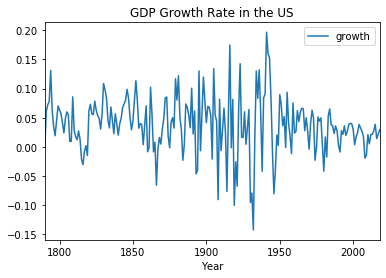

In [58]:
data_location = './data'

data_files = ['USCPI_1774-2018.csv', 'USGDP_1790-2018.csv']
 
data = pd.DataFrame()

cpi_df = pd.read_csv('./data/USCPI_1774-2018.csv')

def calc_append_inflation(cpi_data):
    prev_year = None
    
    cpi_series = cpi_data['CPI']

    inflation_rate = []
    for cpi in cpi_series:

        if prev_year == None:
            inflation_rate.append(0)
        else:
            if_rate = (cpi - prev_year)/prev_year
#             print(if_rate)
            inflation_rate.append(if_rate)
        
        prev_year = cpi
            
#     print(inflation_rate)
    cpi_data['inflation'] = inflation_rate

calc_append_inflation(cpi_df)

gdp_df = pd.read_csv('./data/USGDP_1790-2018.csv')

gdp_df = cpi_df.merge(gdp_df)

nom_gdp = 'Nominal GDP (million of Dollars)'

def calc_gdp_growth(gdp_data):
    prev_year = None
    
    gdp_series = gdp_data[nom_gdp]
    inflation_series = gdp_data['inflation']
    
    growth_rate = []
    for inflation, gdp in zip(inflation_series, gdp_series):
        gdp_f = float(gdp.replace(',', ''))
        
        if prev_year == None:
            growth_rate.append(0)
        else:
            if_amount = (inflation * prev_year) + prev_year
#             print(inflation, prev_year, if_amount)
            growth = (gdp_f - if_amount) / if_amount
#             growth = 1
            growth_rate.append(growth)
            
        prev_year = gdp_f
        
    return growth_rate

gdp_df['growth'] = calc_gdp_growth(gdp_df)
growth_chat = gdp_df[['Year', 'growth']].plot.line(x = 'Year', y = 'growth')
plt.title('GDP Growth Rate in the US')
plt.show(growth_chat)



In [124]:
import re
import datetime
from os import listdir
from os.path import isfile, join

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

title_rx = re.compile(r'title="(.*)"')
date_rx = re.compile(r'date="(.*)"')
quoted_rx = re.compile(r'\"(.+?)"')
angle_bracket_rx = re.compile(r'<(.*)>')

v_analyzer = SentimentIntensityAnalyzer()
def vaderAnalyze(sentence):
    analysis = v_analyzer.polarity_scores(sentence)
    raw_score = analysis['compound']
        
    return raw_score

class SpeechData:
    def __init__(self, date, president, speech, positivity):
        self.date = date
        self.president = president
        self.speech = speech
        self.positivity = positivity
        
    def get_dict(self):
        return {
            'date': self.date,
            'president': self.president,
            'speech': self.speech,
            'positivity': self.positivity
        }

def process_speech_file(file_str, president_name):
    
    file = open(file_str, 'r')

    title_line = file.readline()
    date_line = file.readline()

    title_match = title_rx.search(title_line)
    date_match = date_rx.search(date_line)

    if date_match:
        doc_title = quoted_rx.findall(title_line)[0]
        date_str = quoted_rx.findall(date_line)[0]
    
        try:
            doc_date = datetime.datetime.strptime(date_str, '%B %d, %Y')
        except:
            print('Error: ' + president_name)
            print(file_str)
            print('data_str : ', date_str)
            file.close()
            return None
            
#         print(doc_title, ' : ', doc_date.date())
    
        divider = 1
        score = 0
        interview = False
        for line in file:
            angle_match = angle_bracket_rx.search(line)
            if angle_match:
                interview = True
                continue
            sentences = line.split('. ')
            for sentence in sentences:
                score += vaderAnalyze(sentence)
                score = score / divider
                divider = 2
                
        speech_data = SpeechData(doc_date, president_name, doc_title, score)
        file.close()
#         if interview:
#             print('Interview found:', file_str)
        
        return speech_data
    
    else:
        file.close()
        print('Warning: File had bad formatting.')
        print('file: ' + file_str)
        return None



Error: reagan
./data/Corpus of Presidential Speeches/reagan/reagan_speeches_048.txt
data_str :  Berlin Wall
Error: reagan
./data/Corpus of Presidential Speeches/reagan/reagan_speeches_035.txt
data_str :  Domestic Issues
file: ./data/Corpus of Presidential Speeches/carter/carter_speeches_006.txt
file: ./data/Corpus of Presidential Speeches/lbjohnson/lbjohnson_speeches_062.txt
Error: fdroosevelt
./data/Corpus of Presidential Speeches/fdroosevelt/fdroosevelt_speeches_025.txt
data_str :  Four Freedoms
file: ./data/Corpus of Presidential Speeches/clinton/clinton_speeches_000.txt
file: ./data/Corpus of Presidential Speeches/gwbush/gwbush_speeches_037.txt


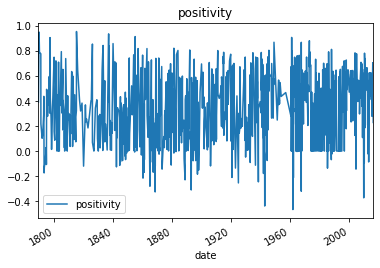

In [125]:
positivity_df = pd.DataFrame(columns=['date', 'president', 'speech', 'positivity'])

# test_file = './data/Corpus of Presidential Speeches/washington/washington_speeches_000.txt'
# interview_test_file = './data/Corpus of Presidential Speeches/coolidge/coolidge_speeches_000.txt'
# date_test_file = './data/Corpus of Presidential Speeches/reagan/reagan_speeches_048.txt'
# weird_format_file = './data/Corpus of Presidential Speeches/carter/carter_speeches_006.txt'
# speech = process_speech_file(test_file, 'washington')
# print(speech.speech, speech.positivity)

# positivity_df = positivity_df.append(speech.get_dict(), ignore_index=True)

speech_dir = './data/Corpus of Presidential Speeches'
contents = listdir(speech_dir)
for f in contents:
    loc = join(speech_dir, f)
    if not isfile(loc):
        for file_name in listdir(loc):
            file_str = join(loc, file_name)
            if isfile(file_str):
#                 print(file_name)
                result = process_speech_file(file_str, f)
                if result is not None:
                    positivity_df = positivity_df.append(result.get_dict(), ignore_index=True)
        
positivity_df

positive_chart = positivity_df[['date', 'positivity']].plot.line(x = 'date', y = 'positivity')
plt.title('positivity')
plt.show(positive_chart)